In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense, Dropout

In [2]:
train_path = "/kaggle/input/self-driving-cars/images"
len(os.listdir(train_path))
train_df = pd.read_csv("/kaggle/input/self-driving-cars/labels_train.csv")
train_df.head()

,frame,xmin,xmax,ymin,ymax,class_id
0,1478019952686311006.jpg,237,251,143,155,1
1,1478019952686311006.jpg,437,454,120,186,3
2,1478019953180167674.jpg,218,231,146,158,1
3,1478019953689774621.jpg,171,182,141,154,2
4,1478019953689774621.jpg,179,191,144,155,1


In [3]:
val_path = "/kaggle/input/self-driving-cars/images"
len(os.listdir(val_path))
val_df = pd.read_csv("/kaggle/input/self-driving-cars/labels_val.csv")
val_df.head()

,frame,xmin,xmax,ymin,ymax,class_id
0,1478899046136829030.jpg,201,206,129,135,5
1,1478899046136829030.jpg,203,210,150,158,1
2,1478899046136829030.jpg,215,219,130,135,5
3,1478899046136829030.jpg,222,234,145,162,1
4,1478899046136829030.jpg,223,235,149,160,1


In [4]:
train_df['class_id'].value_counts()

1    101314
5     12700
3     10637
2      6313
4      1442
Name: class_id, dtype: int64

In [5]:
val_df['class_id'].value_counts()

1    22000
3     4903
5     4553
2     1009
4      234
Name: class_id, dtype: int64

In [6]:
classes = train_df.class_id.unique()
print(len(classes))
print(classes)

5
[1 3 2 5 4]


In [7]:
def train_data_generator(df=train_df, batch_size=8, path=train_path):
    while True:        
        images = np.zeros((batch_size, 300, 480, 3))
        bounding_box_coords = np.zeros((batch_size, 4))
        
        for i in range(batch_size):
                rand_index = np.random.randint(0, train_df.shape[0])
                row = df.loc[rand_index, :]
                img_path = path + '/' + row['frame']
                images[i] = cv2.imread(img_path) / 255.
                bounding_box_coords[i] = np.array([row.xmin, row.ymin, row.xmax, row.ymax])
                
        yield {'image': images}, {'coords': bounding_box_coords}

In [8]:
def val_data_generator(df=val_df, batch_size=8, path=train_path):
    while True:        
        images = np.zeros((batch_size, 300, 480, 3))
        bounding_box_coords = np.zeros((batch_size, 4))
        
        for i in range(batch_size):
                rand_index = np.random.randint(0, val_df.shape[0])
                row = df.loc[rand_index, :]
                img_path = path + '/' + row['frame']
                images[i] = cv2.imread(img_path) / 255.
                bounding_box_coords[i] = np.array([row.xmin, row.ymin, row.xmax, row.ymax])
                
        yield {'image': images}, {'coords': bounding_box_coords}

1479502696257770094.jpg
1478896634722281131.jpg
1479506060983932841.jpg
1478897362546213555.jpg
1478898606243024492.jpg
1478896333653242404.jpg


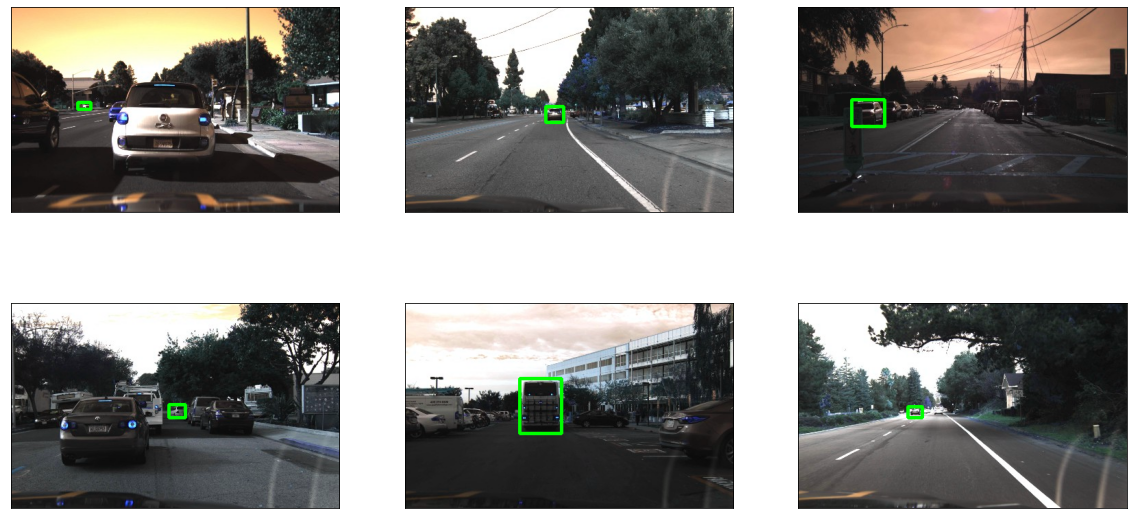

In [9]:
plt.figure(figsize=(20, 10))
for i in range(6):
    random_val = np.random.randint(0, train_df.shape[0])
    print(train_df.loc[random_val, :]['frame'])
    img_path = train_path + '/' + train_df.loc[random_val, :]['frame']
    img = cv2.imread(img_path)
    bbox=(train_df.loc[random_val, :].xmin, train_df.loc[random_val, :].ymin, 
                 train_df.loc[random_val, :].xmax, train_df.loc[random_val, :].ymax)

        # Draw the bounding boxes
    if len(bbox) == 4:
        xmin, ymin, xmax, ymax = bbox
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 3)
    
    plt.subplot(2, 3, i + 1)    
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

1478732535436607898.jpg
[(203, 94, 365, 235), (368, 122, 452, 183), (391, 109, 401, 125)]


([], [])

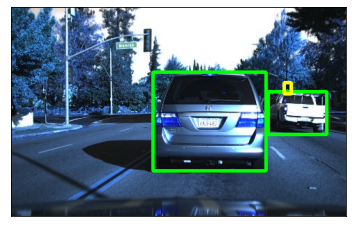

In [10]:
random_val = np.random.randint(0, train_df.shape[0])
print(train_df.loc[random_val, :]['frame'])

bbox_arr = []
label_arr = []
img_name = train_df.loc[random_val, :]['frame']
img_path = train_path + '/'  + img_name

for i in range(len(train_df)):
    if train_df['frame'][i] == img_name:
        box = (train_df['xmin'][i], train_df['ymin'][i], 
                 train_df['xmax'][i], train_df['ymax'][i])
        label = train_df['class_id'][i]
        bbox_arr.append(box)
        label_arr.append(label)
print(bbox_arr)

img = cv2.imread(img_path)
for j in range(len(bbox_arr)):
    if label_arr[j] == 1:
        bb_color = (0, 255, 0) ## CAR
    elif label_arr[j] == 2:
        bb_color = (0, 0, 255) ## TRUCK
    elif label_arr[j] == 3:
        bb_color = (0, 255, 255) ## PEDESTRIAN
    elif label_arr[j] == 4:
        bb_color = (255, 0, 255) ## BYCYCLE
    elif label_arr[j] == 5:
        bb_color = (255, 255, 0)  ## TRAFFIC LIGHT  
    cv2.rectangle(img, (int(bbox_arr[j][0]), int(bbox_arr[j][1])), (int(bbox_arr[j][2]), int(bbox_arr[j][3])), bb_color, 3)
plt.imshow(img)
plt.xticks([])
plt.yticks([])

In [11]:
train_input = Input(shape=[300, 480, 3], name='image')

x = train_input

for i in range(5):
#     n_filters = 2**(i + 2)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = MaxPool2D(2, padding='same')(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    if i in range(2,10,2):
        x= Dropout(0.7)(x)
        x = MaxPool2D(2, padding='same')(x)
        

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(4, name='coords')(x)

model = tf.keras.models.Model(train_input, output)
model.summary()

2022-09-26 11:00:24.458967: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-26 11:00:24.467816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-26 11:00:24.468609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-26 11:00:24.470158: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 300, 480, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 480, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 300, 480, 32)      128       
_________________________________________________________________
dropout (Dropout)            (None, 300, 480, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 240, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 240, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 240, 64)      256   

In [12]:
# from tensorflow.keras.metrics import IoU
from tensorflow.keras.metrics import CategoricalAccuracy
##############################
# optimiser = tf.keras.optimizers.Adam(learning_rate=0.00001)
# iou = tf.keras.metrics.IoU(num_classes=len(classes), target_class_ids=classes)

model.compile( loss={
#     'image' : 'CategoricalCrossentropy',    
    'coords': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics={
#         'image' : 'accuracy',
#         'coords': ['accuracy', CategoricalAccuracy()]
        'coords': 'accuracy'
    })

In [27]:
# with tf.device('/GPU:0'):
history = model.fit(
    train_data_generator(),
    validation_data=val_data_generator(),
    epochs=10,
    steps_per_epoch=500,
   )

Epoch 1/10
500/500 [==============================] - ETA: 0s - loss: 8582.1211 - accuracy: 0.6965

KeyboardInterrupt: 

In [ ]:
model.save('vehicle_detection_v1.h5')